### Phase 5 Project Submission

Student Name: Tai Ngoc Bui

Student Pace: Flex

Scheduled Project Review: December 7th, 2024

Instructor Name: Mark Barbour

### 1. Business Understanding

### 2. Data Understanding

### 3. Exploratory Analysis

#### a. Load Libraries

In [27]:
# Load all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
%matplotlib inline

#### b. Exploratory Analsysis

I will create a function to plot a given number of images from each of the class. This function should require a path to image folder, the title for the plot, and the number of images users want to display.

In [2]:
# Create path for train and test sets
_dir_train = 'data/train'
_dir_test = 'data/test'

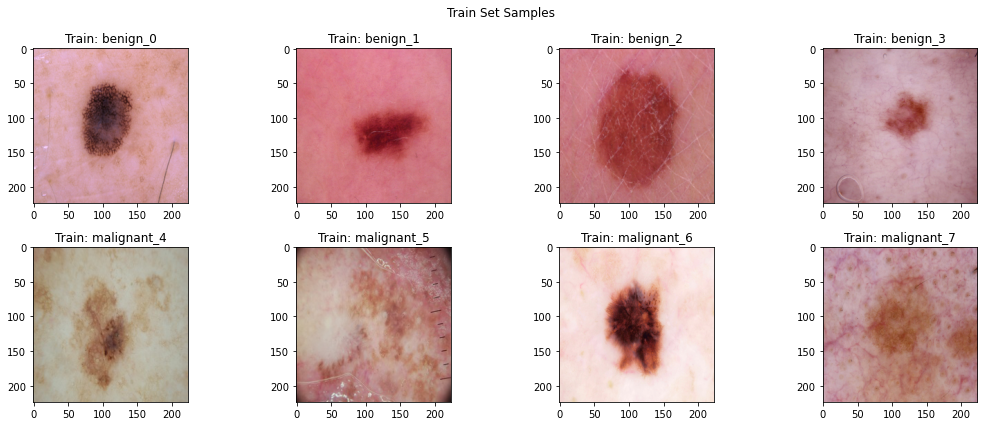

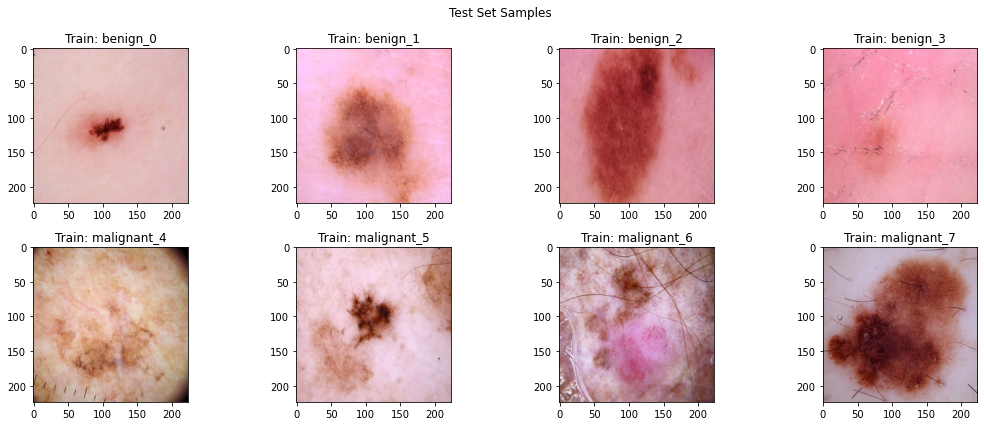

In [3]:
# Function to plot images from a directory
def plot_images_from_directory(directory, title, num):
    '''This function takes in a string path, a string title name, and number of images to be displayed
    The output will plot half of num of images for each class
    '''
    class_names = os.listdir(directory)
    num_classes = len(class_names)
    l = list()
    col = num//2
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
         # Take the n/2 number of images from each class
        for n in range(col):
            image_path = os.path.join(class_dir, os.listdir(class_dir)[n]) 
            l.append((image_path, class_name))       
    
    fig, ax = plt.subplots(2,num//2, figsize = (15,6))

    for i in range(len(l)):
        r = i//col
        c = i%col
        img = load_img(l[i][0], target_size = (224, 224))
        ax[r,c].imshow(img)
        ax[r,c].set_title(f'Train: {l[i][1]}_{i}')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show();

plot_images_from_directory(_dir_train,'Train Set Samples', 8)
plot_images_from_directory(_dir_test,'Test Set Samples', 8)

### 4. Image Preprocessing

In [4]:
# Image Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip = True,
        validation_split = 0.2,
        fill_mode='nearest'
)

# For test set, image augmentation will not be applied to prevent overfitting
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
training_set = train_datagen.flow_from_directory(
    _dir_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset = 'training'
)

validation_set = train_datagen.flow_from_directory(
    _dir_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset = 'validation'
)

# Flow validation images in batches of 32 using test_datagen generator
test_set = test_datagen.flow_from_directory(
    _dir_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = 'False'
)

class_indices = training_set.class_indices
print("Class Indices:", class_indices)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}


### 5. Build a Convolutional Neural Networks (CNNs) as Baseline Model

#### a. Build a Base Model Structure

We start by building a Convolutional Neural Networks (CNNs) as our baseline model. It is designed to automatically learn and extract useful features from the input data, making them highly effective for image classification task as in this case.

The key components of a CNN architecture are:

- Convolutional Layers: These layers apply a set of learnable filters (or kernels) to the input data, extracting local features and patterns. The filters are learned during the training process.

- Pooling Layers: These layers reduce the spatial size of the feature maps, making the representation more manageable and invariant to small translations in the input.

- Fully Connected Layers: These layers connect all neurons from the previous layer to produce the final output, such as class probabilities in a classification task.

In [5]:
# Create an instance of the Sequential model 
base_model = Sequential()

I will use 3 Convolutional layers with increasing filter sizes (32, 64, 128). The "relu" activation function is used in each of the convolution layer to introduce non-linearity, enabling the network to learn complex patterns and relationships in data. Early Convolutional layers detect simple features such as edges, corners, or textures. As the network goes deeper, it needs to learn more complex patterns, such as shapes, structures, and semantic representations. Increasing the number of filters allows the network to capture more varied and complex patterns. Filters act as feature detectors. More filters mean the model can learn a richer set of features at each layer, improving its ability to generalize across diverse input data. On the other hand, starting with too many filters in early layers can lead to overfitting or unnecessary computational overhead since these layers only need to learn simple features. A gradual increase ensures a smooth transition between layers and allows the network to build on the features learned in previous layers. Followed each convolutional layer, a pooling layer is used to reduce the spatial dimensions of the feature maps. 

After Convolutional and Pooling layers, a Dense layer (fully connected) combines these features into a high-dimensional representation. A layer with 256 neurons provides a balance between model capacity and computational efficiency. This size is large enough to capture meaningful patterns but small enough to avoid overfitting.

In [6]:
# Setting up 3 convolutional layers and 3 pooling layers
base_model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', 
           input_shape = (224,224,3)))
base_model.add(MaxPool2D(pool_size = (2,2), strides = 2))
base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
base_model.add(MaxPool2D(pool_size = (2,2), strides = 2))
base_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
base_model.add(MaxPool2D(pool_size = (2,2), strides = 2))
# Flatten layer will flatten previous layers output into single vector
base_model.add(Flatten())

# Add a fully connected layer
base_model.add(Dense(units = 256, activation='relu'))

# Add an output layer with sigmoid as activation function
base_model.add(Dense(units = 1, activation='sigmoid'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

#### b. Compile Base Model

Compiling a CNN model involves specifying the loss function, optimizer, and evaluation metrics. As malignant and benign photos are almost identical under human's eyes, I decided to use  focal loss, which focuses on hard-to-classify examples. It measures the difference between the predicted probability and the actual label, thus working well with sigmoid function at the output layer. With the optimizer, I used Adam optimization, a commonly used optimizer. Adam optimization not only incorporates the advantages of two popular optimization techniques, the Momentum and RMSProp, but also helps the model converge faster compared to vanilla SGD by efficiently navigating through flat or steep regions of the loss surface. Lastly, I used both "Accuracy" and AUC (Area under the curve) as the metric to measure the effectiveness of the model.

In [7]:
# Compile the model

base_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy',  
    metrics=['accuracy', AUC(name='auc')] 
)

I also use 2 callbacks EarlyStopping and ModelCheckpoint to prevent overfitting, save computational resources by halting training when improvements plateau, and ensure that the best model (based on validation loss) is saved during training. 
The model trains for up to 50 epochs but may stop earlier if validation loss does not improve for 5 epochs due to EarlyStopping. During training, the model saves the best weights (with the lowest validation loss) to 'cnn_model_best_weights.h5' using ModelCheckpoint. The history object stores the training and validation loss and metrics for each epoch, which can be used for analysis or plotting.

In [8]:
# Early stopping and model checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('cnn_model_best_weights.h5', save_best_only=True, save_weights_only=True,
                                   monitor='val_loss', mode='min', verbose=1)

history = base_model.fit(
    training_set,
    # Number of steps (batches) in one epoch. Computed as the total samples divided by batch size.
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=50,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.6603 - auc: 0.7269
Epoch 00001: val_loss improved from inf to 0.59848, saving model to cnn_model_best_weights.h5
65/65 [==============================] - 60s 921ms/step - loss: 0.6573 - accuracy: 0.6603 - auc: 0.7269 - val_loss: 0.5985 - val_accuracy: 0.7148 - val_auc: 0.7949
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.7618 - auc: 0.8528
Epoch 00002: val_loss improved from 0.59848 to 0.53652, saving model to cnn_model_best_weights.h5
65/65 [==============================] - 60s 922ms/step - loss: 0.4798 - accuracy: 0.7618 - auc: 0.8528 - val_loss: 0.5365 - val_accuracy: 0.6387 - val_auc: 0.8087
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.7810 - auc: 0.8589
Epoch 00003: val_loss improved from 0.53652 to 0.49781, saving model to cnn_model_best_weights.h5
65/65 [==============================] - 65s 998ms/step - 

#### c. Evaluate the Model

In [9]:
# Evaluate the model
vloss, vaccuracy, *_ = base_model.evaluate(validation_set)
print(f'Validation Loss: {vloss:.4f}')
print(f'Validation Accuracy: {vaccuracy:.4f}')

tloss, taccuracy, *_ = base_model.evaluate(test_set)
print(f'Test set Loss: {tloss:.4f}')
print(f'Test set Accuracy: {taccuracy:.4f}')

17/17 [==============================] - 6s 379ms/step - loss: 0.4688 - accuracy: 0.7780 - auc: 0.8462
Validation Loss: 0.4688
Validation Accuracy: 0.7780
21/21 [==============================] - 4s 172ms/step - loss: 0.3747 - accuracy: 0.8030 - auc: 0.9027
Test set Loss: 0.3747
Test set Accuracy: 0.8030


This CNN model shows a decent performance with the test set with 80.3% accuracy and AUC is 0.9027. Next, I will graph the training set and validation set's accuracy and loss metrics.

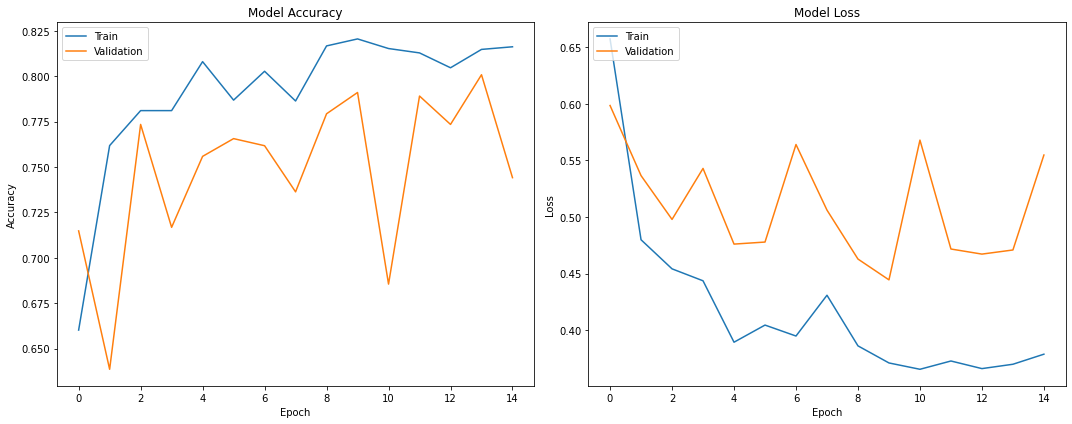

In [10]:
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

#### d. Generate Confusion Matrix and Additional Metrics

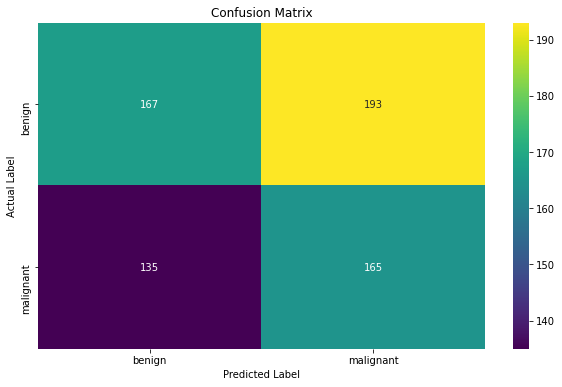

Classification Report:

Class: benign
precision: 0.5529801324503312
recall: 0.4638888888888889
f1-score: 0.5045317220543808
support: 360

Class: malignant
precision: 0.46089385474860334
recall: 0.55
f1-score: 0.5015197568389059
support: 300

Class: macro avg
precision: 0.5069369935994672
recall: 0.5069444444444444
f1-score: 0.5030257394466433
support: 660

Class: weighted avg
precision: 0.5111227334950004
recall: 0.503030303030303
f1-score: 0.5031626469564376
support: 660


In [11]:
predictions = base_model.predict(test_set)
y_pred = y_pred = np.where(predictions > 0.5, 1, 0)

# Confusion Matrix
cm = confusion_matrix(test_set.classes, y_pred)
class_names = list(test_set.class_indices.keys())

# Classification Report
cr = classification_report(test_set.classes, y_pred, target_names=class_names, output_dict=True)

# ROC Curve
fpr, tpr, _ = roc_curve(test_set.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show();

print('Classification Report:')
for key, value in cr.items():
    if isinstance(value, dict):
        print(f'\nClass: {key}')
        for k, v in value.items():
            print(f'{k}: {v}')


The recall rate for the model is 64.3% despite accuracy achieves79.55%. For a medical detection problem, I will need to find a way to improve recall rate of this model. Here, I will utilize the ResNet50 model, a popular model for medical detection with small data set. 

### 6. ResNet50


#### a. Image Preprocessing

In [17]:
# Image Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip = True,    
        fill_mode='nearest',
        validation_split = 0.2
)

# For test set, image augmentation will not be applied to prevent overfitting
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
training_set = train_datagen.flow_from_directory(
    _dir_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset = 'training'
)

validation_set = train_datagen.flow_from_directory(
    _dir_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset = 'validation'
)

# Flow validation images in batches of 32 using test_datagen generator
test_set = test_datagen.flow_from_directory(
    _dir_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = 'False'
)

class_indices = training_set.class_indices
print("Class Indices:", class_indices)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}


The reason I decide to use RestNet 50 is due to its proven success in various medical image classification tasks. ResNet50 is well-suited for medical image detection problems, including tasks like skin cancer classification, due to its innovative architecture and ability to handle complex features in image data. On the other hand, I also prevents the weights of the pre-trained layers from being updated during training. Freezing ensures that the base model serves as a fixed feature extractor while the custom layers learn task-specific patterns.


#### b. Load ResNet50 and Add Customize Layers

In [ ]:
# Load ResNet50
RN = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Prevents the weights of the pre-trained layers from being updated during training
for layer in RN.layers:
    layer.trainable = False
    
# Add custom classification layers
x = RN.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and custom layers
model = Model(inputs=RN.input, outputs=predictions)

#### c. Train Model

In [18]:
# Compile the model
model.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    epochs=30,
    callbacks=[early_stopping]
)

# Save the model
model.save('RestNet_model_best_weights.h5')

Epoch 1/30
65/65 [==============================] - 83s 1s/step - loss: 0.7060 - accuracy: 0.5318 - auc: 0.5314 - val_loss: 0.6716 - val_accuracy: 0.5566 - val_auc: 0.8335
Epoch 2/30
65/65 [==============================] - 82s 1s/step - loss: 0.6749 - accuracy: 0.5683 - auc: 0.5984 - val_loss: 0.6607 - val_accuracy: 0.7734 - val_auc: 0.8342
Epoch 3/30
65/65 [==============================] - 84s 1s/step - loss: 0.6689 - accuracy: 0.5991 - auc: 0.6143 - val_loss: 0.6440 - val_accuracy: 0.5859 - val_auc: 0.8400
Epoch 4/30
65/65 [==============================] - 83s 1s/step - loss: 0.6500 - accuracy: 0.6059 - auc: 0.6700 - val_loss: 0.6733 - val_accuracy: 0.4570 - val_auc: 0.8436
Epoch 5/30
65/65 [==============================] - 83s 1s/step - loss: 0.6455 - accuracy: 0.6290 - auc: 0.6787 - val_loss: 0.6130 - val_accuracy: 0.6602 - val_auc: 0.8505
Epoch 6/30
65/65 [==============================] - 83s 1s/step - loss: 0.6279 - accuracy: 0.6424 - auc: 0.7291 - val_loss: 0.6772 - val_acc

#### d. Evaluate Model

In [19]:
# Evaluate the model
vloss, vaccuracy, *_ = model.evaluate(validation_set)
print(f'Validation Loss: {vloss:.4f}')
print(f'Validation Accuracy: {vaccuracy:.4f}')

tloss, taccuracy, *_ = model.evaluate(test_set)
print(f'Test set Loss: {tloss:.4f}')
print(f'Test set Accuracy: {taccuracy:.4f}')

17/17 [==============================] - 16s 970ms/step - loss: 0.5129 - accuracy: 0.7875 - auc: 0.8705
Validation Loss: 0.5129
Validation Accuracy: 0.7875
21/21 [==============================] - 20s 945ms/step - loss: 0.5381 - accuracy: 0.7636 - auc: 0.8414
Test set Loss: 0.5381
Test set Accuracy: 0.7636


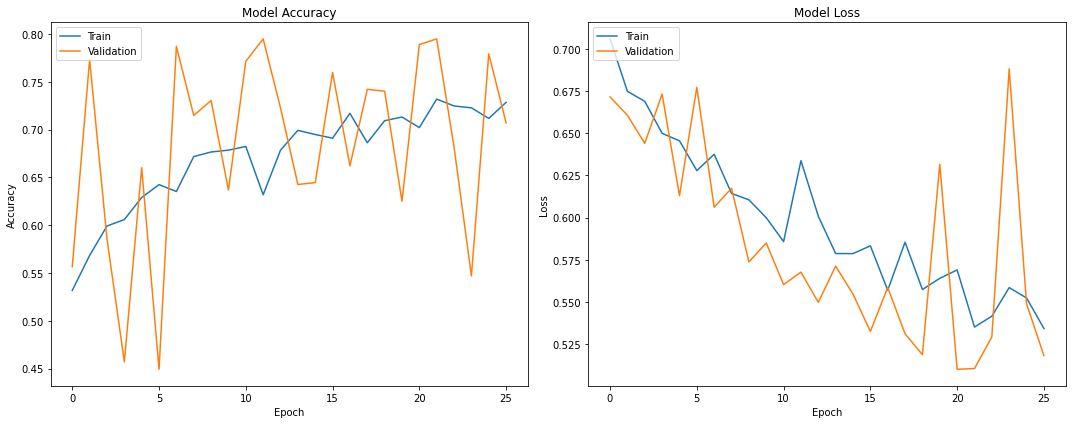

In [20]:
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

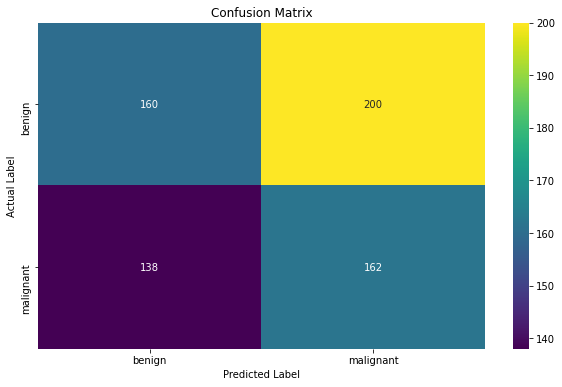

Classification Report:

Class: benign
precision: 0.5369127516778524
recall: 0.4444444444444444
f1-score: 0.486322188449848
support: 360

Class: malignant
precision: 0.44751381215469616
recall: 0.54
f1-score: 0.48942598187311176
support: 300

Class: macro avg
precision: 0.4922132819162742
recall: 0.4922222222222222
f1-score: 0.4878740851614799
support: 660

Class: weighted avg
precision: 0.4962768700764177
recall: 0.48787878787878786
f1-score: 0.48773300364224065
support: 660


In [21]:
predictions = model.predict(test_set)
y_pred = np.where(predictions > 0.5, 1, 0)

# Confusion Matrix
cm = confusion_matrix(test_set.classes, y_pred)
class_names = list(test_set.class_indices.keys())

# Classification Report
cr = classification_report(test_set.classes, y_pred, target_names=class_names, output_dict=True)

# ROC Curve
fpr, tpr, _ = roc_curve(test_set.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show();

print('Classification Report:')
for key, value in cr.items():
    if isinstance(value, dict):
        print(f'\nClass: {key}')
        for k, v in value.items():
            print(f'{k}: {v}')

With the use of Resnet50 model, there is no improvement in both recall rate for the malignant class and accuracy. The cause of such low recall rate may result from lack of preprocessing process. Though I already did certain image augmentation process for training set, such process may not be robust enough for the ResNet50 model.

###  7. Hybrid Model with XGBoost and ResNet50

In the final part of this project, I will create a hybrid model, combining ResNet50's feature extraction process with the XGBoost model. A hybrid model combining ResNet50 for feature extraction and XGBoost for classification often performs better than using ResNet50 alone for end-to-end classification.  While ResNet50 specializes in extracting high-level features from images (e.g., edges, textures, shapes), XGBoost excels in handling structured data and learning complex decision boundaries efficiently. Moreover, fine-tuning ResNet50 end-to-end on a small dataset can lead to overfitting due to the large number of parameters. Thus, using ResNet50 as a frozen feature extractor reduces the risk of overfitting by focusing only on pre-trained feature extraction. XGBoost, with regularization parameters, helps generalize well even on small datasets.

#### a. Load ResNet50 for Feature Extraction

In [ ]:
# Excludes the final fully connected (classification) layer.
RN_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Applies ResNet50-specific preprocessing, such as scaling pixel values to match ImageNet training.
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# shuffle=False to maintains the original order of images, important for linking features with labels later.
training_set = datagen.flow_from_directory(
    _dir_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Passes images through ResNet50 to extract high-level features.
features = RN_model.predict(training_set)
labels = training_set.classes

# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=50)

#### b. Train XGBoost Model with ResNet50 Feature Extraction

In [ ]:
# A gradient boosting decision tree algorithm for binary classification problem with logistic loss.
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
#                               Builds 100 trees in the ensemble.
                              n_estimators=100, 
#                               Controls the contribution of each tree to the final prediction
                              learning_rate=0.1, 
                              max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
# Predict labels for the test set
y_pred = xgb_model.predict(X_test)

#### c. Evaluate Hybrid Model

Found 2637 images belonging to 2 classes.


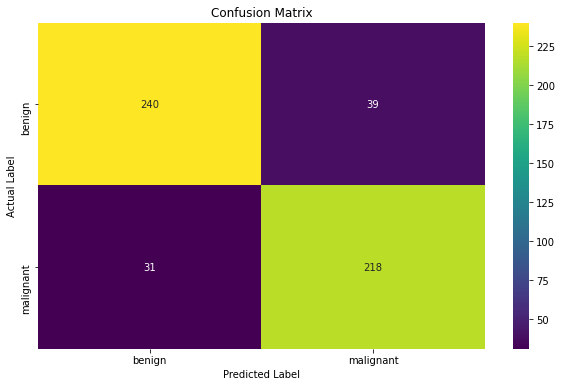

Accuracy: 0.8674
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       279
           1       0.85      0.88      0.86       249

    accuracy                           0.87       528
   macro avg       0.87      0.87      0.87       528
weighted avg       0.87      0.87      0.87       528



In [28]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = list(test_set.class_indices.keys())
# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show();

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


#### d. Feature Importance

I will visualize the feature importance of the xgb model. The plot will display the top 20 contributing features from the ResNet50 feature extraction step (used by XGBoost). Each bar will represent the importance of a feature, with a clear title, labels, and colors. The importance ranks how these high-dimensional features contribute to predictions.

<Figure size 1080x720 with 0 Axes>

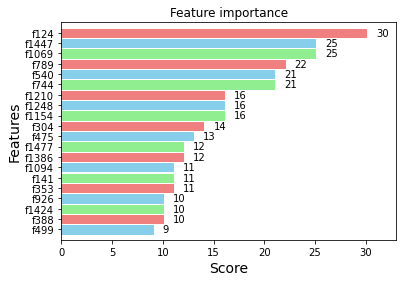

In [33]:
# Visualize Feature Importance - Ranks features based on their usage in splits across trees
plt.figure(figsize=(15, 10))
ax = xgb.plot_importance(xgb_model, importance_type='weight',
                         max_num_features=20,  # Adjust the number of features to display
                         color='skyblue', 
                         height=0.8)

# Customize the plot to make it colorful
# ax.set_title('Feature Importance (XGBoost)', fontsize=16)
ax.set_xlabel('Score', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.grid(False)


# Add a color theme
for i, bar in enumerate(ax.patches):
    if i % 3 == 0:
        bar.set_color('skyblue')
    elif i % 3 == 1:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightgreen')

plt.show();